# Data extraction

Send request for BTC pricing data and store response locally.

In [2]:
import requests

response = requests.get("https://www.satochi.co/allBTCPrice")

with open("btc_raw.txt","wb") as file:
    file.write(response.content)

Send request for VT and IGLO pricing data and store responses locally

In [3]:
import requests

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36",
    "X-Requested-With": "XMLHttpRequest"
}

payload = {
    "header": "%s Historical Data",
    "st_date": "19/08/2008",
    "end_date": "19/09/2021",
    "interval_sec": "Daily",
    "sort_col": "date",
    "sort_ord": "DESC",
    "action": "historical_data"
}

url = "https://uk.investing.com/instruments/HistoricalDataAjax"

etfs = [
    {
        "header":"iglo", 
        "curr_id": 45629,
        "smlID": 2530788,
    },
    {
        "header":"vt", 
        "curr_id": 38224,
        "smlID": 2505638,
    }
]

for etf in etfs:
    payload_etf = payload.copy()
    payload_etf["header"] = payload_etf["header"] % etf["header"].upper()
    payload_etf["curr_id"] = etf["curr_id"]
    payload_etf["smlID"] = etf["smlID"]

    response = requests.post(url, data=payload_etf, headers=headers)

    with open(etf["header"]+"_raw.txt", "wb") as file:
        file.write(response.content)

# Data preparation

Convert BTC response data into DataFrame

In [2]:
import pandas as pd

with open("btc_raw.txt", "rb") as file:
    btc = pd.read_json(file)
    
btc.columns = ["date","btc"]
btc["date"] = pd.to_datetime(btc["date"])
btc = btc.set_index("date")

Convert ETF responses into DataFrames

In [3]:
def html_read(etf):
    df = pd.read_html(etf+"_raw.txt")[0]
    df = df.loc[:,["Date","Price"]]
    df.columns = ["date", etf]
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")
    
    return df

vt = html_read("vt")
iglo = html_read("iglo")

Combine all dataframes into a single one.

NOTE: the Bitcoin DataFrame covers all days in the time series.

In [4]:
combined_df = pd.concat([btc,vt,iglo], axis=1)

columns = ["btc","eqt","bnd"]
combined_df.columns = columns

Clip dataframe so it has no `NaN`'s at the start or end

In [5]:
non_nulls = combined_df[
    (combined_df["btc"]>0) & (combined_df["bnd"]>0) 
    & (combined_df["eqt"]>0)]

df_start = non_nulls.index[0]
df_end = non_nulls.index[-1]

combined_df = combined_df.loc[df_start:df_end]

Fill `NaN` values in the middle with the previous values

In [6]:
combined_df = combined_df.fillna(method="ffill")

# Correlation matrix chart

Create DataFrame of rolling log returns

In [51]:
import numpy as np

log_df = combined_df.copy()

for col in columns:
    log_df[col+"-log"] = np.log(log_df[col])
    
def my_fun(x):
    return x.iloc[-1] - x.iloc[0]

corr_df = log_df.rolling(window=356).apply(my_fun).iloc[356:,3:]
corr_df.columns = ["Bitcoin", "Equities", "Bonds"]

Create chart

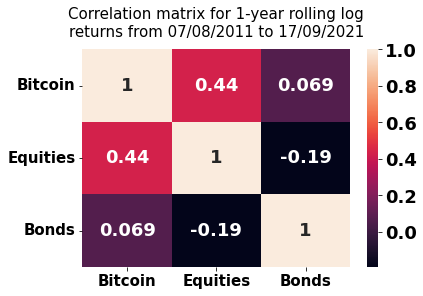

In [52]:
import matplotlib.pyplot as plt
import seaborn as sn

corr = corr_df.corr()

params = {
    "axes.facecolor":"white",
    "figure.facecolor":"white",
    "font.size": 18,
    "font.weight": 1000,
    "axes.titlepad": 13,
}

plt.rcParams.update(params)

start_date = corr_df.index[0].strftime("%d/%m/%Y")
end_date = corr_df.index[-1].strftime("%d/%m/%Y")

title = "Correlation matrix for 1-year rolling log\nreturns from {} to {}".format(start_date,end_date)

res = sn.heatmap(corr, annot=True)

res.set_title(title,fontsize=15)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 15)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 15)

plt.yticks(rotation=0)

plt.savefig("btc-corr.png",bbox_inches='tight')

plt.show()
plt.close()

# Correlation changes over time

Split the combined dataframe by year

In [53]:
corr_copy = corr_df.copy()

corr_copy['year'] = corr_copy.index.year

years = corr_copy["year"].unique()

split_df = [{"year":y,"df":corr_copy[corr_copy['year'] == y]} for y in years]

Create dataframe for correlation matrices timeseries

In [54]:
hist = pd.DataFrame(data=[[x["year"],
 x["df"]["Bitcoin"].corr(x["df"]["Equities"]),
 x["df"]["Bitcoin"].corr(x["df"]["Bonds"]),
 x["df"]["Bonds"].corr(x["df"]["Equities"])]
 for x in split_df],
             columns=["Year","Bitcoin / Equities","Bitcoin / Bonds","Equities / Bonds"])

hist.iloc[:,1:] = hist.iloc[:,1:]
hist = hist.set_index("Year")

Generate chart

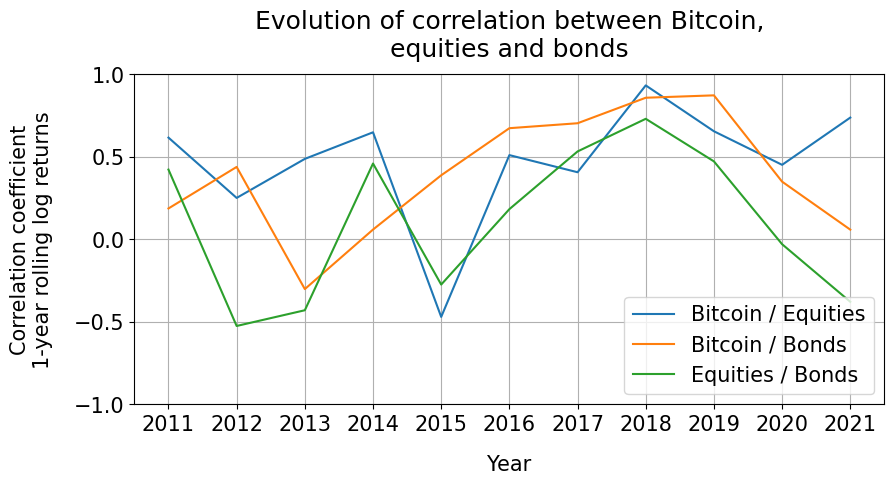

In [55]:
plt.rcParams.update(plt.rcParamsDefault)

newParams = {
    "axes.labelsize": 15,
    "font.size": 15,
    "axes.titlepad": 13,
    "axes.labelpad": 15,
    "figure.subplot.bottom": 0.18,
    "figure.subplot.left": 0.15,
    "figure.subplot.top": 0.84
}

plt.rcParams.update(newParams)

fig = hist.plot(ylim=(-1,1),xticks=years,figsize=(10,5),grid=True).get_figure()
title = "Evolution of correlation between Bitcoin,\nequities and bonds"

plt.title(title)

y = plt.ylabel("Correlation coefficient\n1-year rolling log returns")

fig.savefig("btc-corr-ts.png")

# Backtest

Add columns for all portfolio combinations

In [7]:
from dateutil.relativedelta import relativedelta

backtest_df = combined_df.copy()

FUND_OPTIONS = [
    {
        "name": "10% Bitcoin / 90% Equities",
        "weights": {
            "btc": 0.1,
            "eqt": 0.9
        },
    }, 
    {
        "name": "10% Bitcoin / 90% Bonds",
        "weights": {
            "btc": 0.1,
            "bnd": 0.9
        }
    },
    {
        "name": "80% Equities / 20% Bonds",
        "weights": {
            "eqt": 0.8,
            "bnd": 0.2
        }
    },
    {
        "name": "10% Bitcoin / 75% Equities / 15% Bonds",
        "weights": {
            "eqt": 0.75,
            "bnd": 0.15,
            "btc": 0.1
        }
    }
]

initial_value = 1000
revaluation_period = relativedelta(months=3)


In [8]:
import copy

fund_list = []

for option in FUND_OPTIONS:

    fund_date = df_start
    fund = []

    asset_prices = backtest_df.loc[fund_date]
    fund_append = {
        "date": fund_date,
        "value": initial_value,
        "constituents": {}
    }

    weights = option["weights"]

    for ticker, weight in weights.items():
        fund_append["constituents"][ticker] = initial_value * weight / asset_prices[ticker]

    last_rebalance = fund_date

    fund.append(fund_append)
    fund_date += relativedelta(days=1)

    while fund_date <= df_end:
        last_fund = copy.deepcopy(fund[-1])

        asset_prices = backtest_df.loc[fund_date]

        fund_value = 0

        constituents = last_fund["constituents"]

        for ticker, units in constituents.items():
            fund_value += asset_prices[ticker] * units

        fund_append = {**last_fund, **{
            "date": fund_date,
            "value": fund_value
        }}

        if last_rebalance + revaluation_period == fund_date:
            
            for ticker in constituents.keys():
                fund_append["constituents"][ticker] = fund_value * weights[ticker] / asset_prices[ticker]

            last_rebalance = fund_date

        fund.append(fund_append)

        fund_date += relativedelta(days=1)
        
    fund_df = {
        "name": option["name"],
        "df": pd.DataFrame.from_dict(fund)
    }

    fund_list.append(fund_df)

In [35]:
cf = []

for fund in fund_list:
    df = fund["df"].copy().set_index("date")
    df = df.drop(["constituents"],axis=1)
    df.columns=[fund["name"]]
    cf.append(df)

In [48]:
cf.append(backtest_df)

bt = pd.concat(cf,axis=1).drop("btc",axis=1)

columns = list(bt.columns)
columns[-1] = "100% Bonds"
columns[-2] = "100% Equities"
bt.columns = columns

Calculate returns

In [87]:
returns_1y = ((bt.iloc[-1] / bt.iloc[-356]) - 1) * 100
returns_5y = ((bt.iloc[-1] / bt.iloc[-356*5] - 1) / 5) * 100
returns_total = ((bt.iloc[-1] / bt.iloc[1] - 1) / len(bt) * 356) * 100

Calculate standard deviation, min and max returns for monthly

In [88]:
from datetime import timedelta

def return_fun(x):
    return (x.iloc[-1] / x.iloc[0] - 1) * 100

quarterly_df = bt.resample(timedelta(days=90)).apply(return_fun)

stdev = quarterly_df.std()
minimum = quarterly_df.min()
maximum = quarterly_df.max()

In [89]:
bt_output = pd.concat([returns_1y,returns_5y,returns_total,stdev,minimum,maximum],axis=1)
bt_output.columns = ["1-year return", "5-year annualised return", "Annualised return, 2010-2021", "Standard deviation, monthly returns" , "Minimum, monthly returns", "Maximum, monthly returns"]

In [90]:
bt_output

,1-year return,5-year annualised return,"Annualised return, 2010-2021","Standard deviation, monthly returns","Minimum, monthly returns","Maximum, monthly returns"
10% Bitcoin / 90% Equities,58.315557,42.479339,238.865580,15.601389,-23.597059,50.481146
10% Bitcoin / 90% Bonds,22.684938,19.627387,115.364149,12.982707,-10.039024,52.892582
80% Equities / 20% Bonds,24.943221,12.497608,9.948955,6.199139,-19.799988,15.040554
10% Bitcoin / 75% Equities / 15% Bonds,51.882869,38.326804,214.860633,14.933877,-19.483087,50.893901
100% Equities,32.534678,15.797003,13.088264,7.757859,-25.107745,18.732394
100% Bonds,-2.200034,0.930822,0.283330,2.606497,-6.285043,6.004996
